<a href="https://colab.research.google.com/github/Drisyakr/AICTE-internship-june/blob/main/week3%20garbage%20classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Inspecting: /content/garbage/garbage/TrashType_Image_Dataset

📁 cardboard: 10 images
📁 glass: 6 images
📁 metal: 8 images
📁 paper: 10 images
📁 plastic: 18 images
📁 trash: 9 images
Total images: 61
Found 47 files belonging to 9 classes.
Found 14 files belonging to 9 classes.
Train set: Counter({'plastic': 14, 'cardboard': 8, 'paper': 8, 'trash': 7, 'metal': 6, 'glass': 4})
Val set: Counter({'plastic': 4, 'cardboard': 2, 'paper': 2, 'trash': 2, 'glass': 2, 'metal': 2})
35839040/35839040 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 31s 8s/step - accuracy: 0.0388 - loss: 2.3838 - val_accuracy: 0.2857 - val_loss: 2.0513
Epoch 2/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 906ms/step - accuracy: 0.2394 - loss: 2.0334 - val_accuracy: 0.3571 - val_loss: 1.9087
Epoch 3/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 924ms/step - accuracy: 0.3273 - loss: 1.8330 - val_accuracy: 0.3571 - val_loss: 1.7792
Epoch 4/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.5667 - loss: 1.6299 - val_accuracy: 0.42

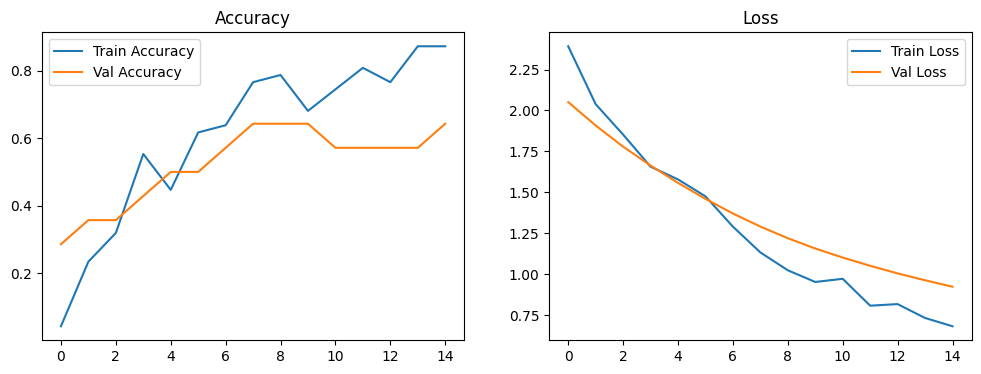

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Validation set contains classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

Classification Report:
              precision    recall  f1-score   support

   cardboard       1.00      0.50      0.67         2
       glass       0.00      0.00      0.00         2
       metal       0.00      0.00      0.00         2
       paper       0.67      1.00      0.80         2
     plastic       0.50      1.00      0.67         4
       trash       1.00      1.00      1.00         2

    accuracy                           0.64        14
   macro avg       0.53      0.58      0.52        14
weighted avg       0.52      0.64      0.54        14



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


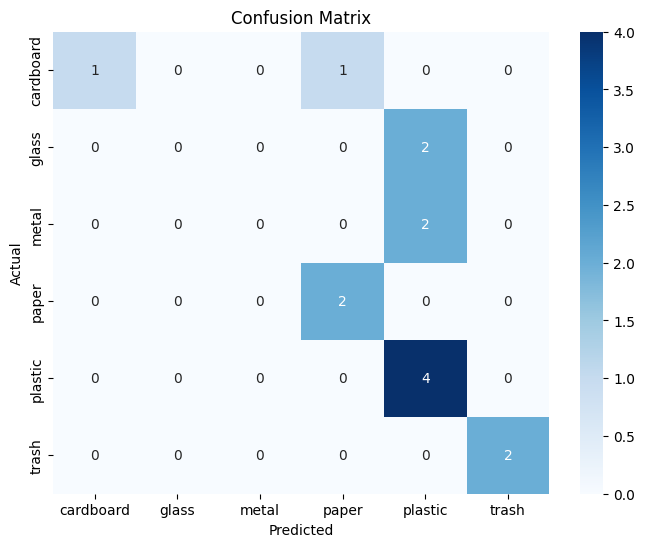

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://b9b1ca986b10005492.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [24]:
# -------------------- Imports --------------------
import os
import random
import shutil
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.applications import EfficientNetV2B2
from tensorflow.keras.layers import GlobalAveragePooling2D
from sklearn.metrics import classification_report, confusion_matrix
import gradio as gr
import collections

# -------------------- Parameters --------------------
original_dataset_dir = "/content/garbage/garbage/TrashType_Image_Dataset"
split_dataset_dir = "/content/garbage"
img_size = (128, 128)
batch_size = 32
seed = 42

# -------------------- Inspect Dataset --------------------
def inspect_dataset_structure(dataset_dir):
    print(f"\nInspecting: {dataset_dir}\n")
    total_images = 0
    for class_name in sorted(os.listdir(dataset_dir)):
        class_path = os.path.join(dataset_dir, class_name)
        if os.path.isdir(class_path):
            num_images = len([
                f for f in os.listdir(class_path)
                if f.lower().endswith(('.jpg', '.jpeg', '.png'))
            ])
            print(f"📁 {class_name}: {num_images} images")
            total_images += num_images
    print(f"Total images: {total_images}")

inspect_dataset_structure(original_dataset_dir)

# -------------------- Split Dataset --------------------
def split_dataset(source_dir, dest_dir, split_ratio=0.2):
    random.seed(42)
    source_dir = Path(source_dir)
    dest_dir = Path(dest_dir)

    for class_dir in source_dir.iterdir():
        if class_dir.is_dir():
            images = list(class_dir.glob("*.jpg")) + list(class_dir.glob("*.jpeg")) + list(class_dir.glob("*.png"))

            random.shuffle(images)

            # Ensure at least 1 image in each split if possible
            if len(images) >= 2:
                split_idx = max(1, int(len(images) * (1 - split_ratio)))
            else:
                split_idx = len(images)

            train_images = images[:split_idx]
            val_images = images[split_idx:]

            for split, split_images in zip(['train', 'val'], [train_images, val_images]):
                target_dir = dest_dir / split / class_dir.name
                target_dir.mkdir(parents=True, exist_ok=True)
                for img in split_images:
                    shutil.copy(img, target_dir / img.name)

split_dataset(original_dataset_dir, split_dataset_dir)

# -------------------- Load Dataset --------------------
train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(split_dataset_dir, "train"),
    image_size=img_size,
    batch_size=batch_size,
    label_mode='int',
    seed=seed
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(split_dataset_dir, "val"),
    image_size=img_size,
    batch_size=batch_size,
    label_mode='int',
    seed=seed
)

class_names = train_ds.class_names
num_classes = len(class_names)

# -------------------- Count Labels --------------------
def count_labels(dataset):
    label_counts = collections.Counter()
    for _, labels in dataset:
        for label in labels.numpy():
            label_counts[class_names[label]] += 1
    return label_counts

print("Train set:", count_labels(train_ds))
print("Val set:", count_labels(val_ds))

# -------------------- Prefetch --------------------
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# -------------------- Data Augmentation --------------------
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1),
])

# -------------------- Build Model --------------------
base_model = EfficientNetV2B2(include_top=False, input_shape=img_size + (3,), weights='imagenet')
base_model.trainable = False

model = Sequential([
    layers.Input(shape=img_size + (3,)),
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# -------------------- Train --------------------
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[early_stopping]
)

# -------------------- Plot Accuracy & Loss --------------------
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Val Accuracy")
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.title("Loss")
plt.legend()
plt.show()

# -------------------- Evaluate --------------------
def evaluate_model(model, dataset):
    y_true = np.concatenate([y.numpy() for x, y in dataset])
    y_pred = np.argmax(model.predict(dataset), axis=1)

    present_classes = np.unique(y_true)
    present_class_names = [class_names[i] for i in present_classes]

    print("Validation set contains classes:", present_class_names)

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=present_class_names))

    cm = confusion_matrix(y_true, y_pred, labels=present_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d',
                xticklabels=present_class_names,
                yticklabels=present_class_names,
                cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

evaluate_model(model, val_ds)

# -------------------- Save Model --------------------
model.save("EfficientNetV2B2_GarbageClassifier.keras")

# -------------------- Gradio Interface --------------------
def classify_image(img):
    img = img.resize(img_size)
    img_array = np.array(img).astype("float32") / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    pred = model.predict(img_array)[0]
    return {class_names[i]: float(pred[i]) for i in range(len(class_names))}

gr.Interface(
    fn=classify_image,
    inputs=gr.Image(type="pil"),
    outputs=gr.Label(num_top_classes=3),
    title="Garbage Classifier",
    description="Upload a garbage image to classify it (e.g., cardboard, glass, plastic, etc.)"
).launch()